In [0]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
%tensorflow_version 1.x
from tensorflow.python.data import Dataset
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib import gridspec

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10


In [9]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
15939,-122.43,37.75,52.0,2960.0,623.0,1191.0,589.0,3.9500,347.7
2761,-117.70,33.62,19.0,2957.0,492.0,1639.0,495.0,5.0686,225.6
4970,-118.11,34.01,41.0,815.0,252.0,775.0,231.0,2.2847,190.0
13162,-121.89,37.32,43.0,1105.0,241.0,982.0,206.0,2.1149,184.9
15201,-122.27,37.87,35.0,3218.0,1108.0,1675.0,1000.0,1.7464,216.7
...,...,...,...,...,...,...,...,...,...
4419,-118.03,34.01,10.0,6531.0,1036.0,2975.0,1018.0,6.2319,403.7
6031,-118.22,34.06,34.0,1083.0,364.0,1132.0,338.0,2.2344,153.1
5841,-118.20,34.04,52.0,1249.0,307.0,1223.0,297.0,2.0700,136.3
16464,-122.61,38.24,17.0,1728.0,271.0,897.0,284.0,3.4896,185.9


In [0]:
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epochs=None):
  features = {key:np.array(value) for key,value in dict(features).items()}
  ds = Dataset.from_tensor_slices((features,targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
  features,labels = ds.make_one_shot_iterator().get_next()
  return features,labels

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

Training model...
RMSE (on training data):
  period 00 : 212.75
  period 01 : 189.67
  period 02 : 169.67
  period 03 : 152.80
  period 04 : 141.12
  period 05 : 134.40
  period 06 : 131.65
  period 07 : 131.06
  period 08 : 131.00
  period 09 : 131.76
Model training finished.
Final RMSE (on training data): 131.76


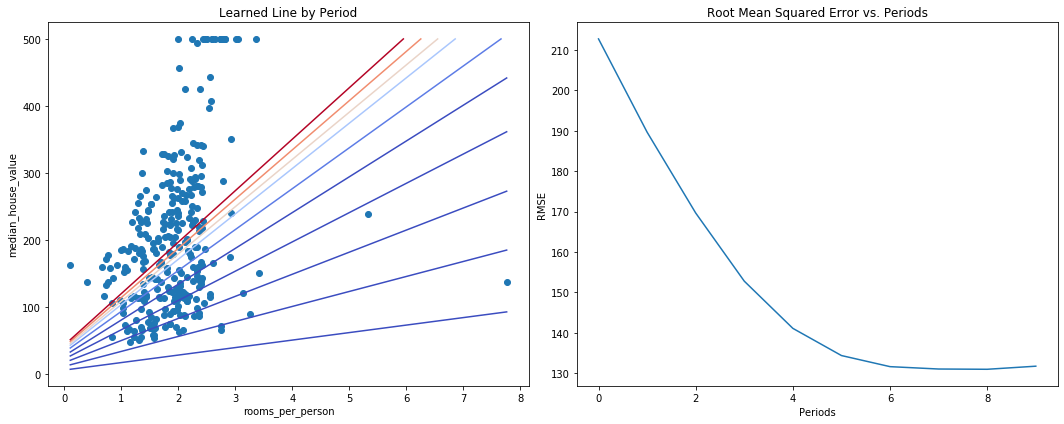

In [14]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")